In [7]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import seaborn as sns
from typing import Tuple, List, Dict, Any

In [9]:
class EnhancedGradientDescent:
    def __init__(self, learning_rate: float = 0.01, max_iterations: int = 1000,
                 tolerance: float = 1e-6, track_metrics: bool = True):
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.tolerance = tolerance
        self.track_metrics = track_metrics

        # Tracking metrics for empirical analysis
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []
        self.convergence_info = {}

    def sigmoid(self, z: np.ndarray) -> np.ndarray:
        """Stable sigmoid function"""
        return np.where(z >= 0,
                       1 / (1 + np.exp(-z)),
                       np.exp(z) / (1 + np.exp(z)))

    def compute_cost_and_gradients(self, X: np.ndarray, y: np.ndarray,
                                  weights: np.ndarray, problem_type: str) -> Tuple[float, np.ndarray]:
        """
        Compute cost and gradients for different problem types

        Args:
            X: Feature matrix (m x n)
            y: Target values (m,)
            weights: Current weights (n,)
            problem_type: 'regression', 'classification', 'non_convex'

        Returns:
            cost: Current cost value
            gradients: Gradient vector
        """
        m = X.shape[0]

        if problem_type == 'regression':
            # Linear regression (convex)
            predictions = X @ weights
            cost = (1 / (2 * m)) * np.sum((predictions - y) ** 2)
            gradients = (1 / m) * X.T @ (predictions - y)

        elif problem_type == 'classification':
            # Logistic regression (convex)
            z = X @ weights
            predictions = self.sigmoid(z)
            # Add small epsilon to prevent log(0)
            epsilon = 1e-15
            predictions = np.clip(predictions, epsilon, 1 - epsilon)

            cost = -(1 / m) * np.sum(y * np.log(predictions) + (1 - y) * np.log(1 - predictions))
            gradients = (1 / m) * X.T @ (predictions - y)

        elif problem_type == 'non_convex':
            # Non-convex function example: Rosenbrock-like function
            # f(w) = sum((w[i+1] - w[i]^2)^2 + 0.01*(1 - w[i])^2)
            cost = 0
            gradients = np.zeros_like(weights)

            for i in range(len(weights) - 1):
                cost += (weights[i+1] - weights[i]**2)**2 + 0.01 * (1 - weights[i])**2

                # Gradients for non-convex function
                gradients[i] += -4 * weights[i] * (weights[i+1] - weights[i]**2) - 0.02 * (1 - weights[i])
                gradients[i+1] += 2 * (weights[i+1] - weights[i]**2)

        return cost, gradients

    def add_gradient_noise(self, gradients: np.ndarray, noise_level: float = 0.01) -> np.ndarray:
        """Add noise to gradients for robustness analysis"""
        if noise_level > 0:
            noise = np.random.normal(0, noise_level, gradients.shape)
            return gradients + noise
        return gradients

    def fit(self, X: np.ndarray, y: np.ndarray, problem_type: str = 'classification',
            noise_level: float = 0.0) -> Dict[str, Any]:
        """
        Fit the model using gradient descent

        Args:
            X: Feature matrix
            y: Target values
            problem_type: 'regression', 'classification', 'non_convex'
            noise_level: Amount of noise to add to gradients

        Returns:
            Dictionary with training results and analysis
        """
        # Initialize weights
        n_features = X.shape[1]
        weights = np.random.normal(0, 0.1, n_features)

        # Reset tracking
        self.cost_history = []
        self.gradient_norms = []
        self.weight_history = []

        prev_cost = float('inf')

        for iteration in range(self.max_iterations):
            # Compute cost and gradients
            cost, gradients = self.compute_cost_and_gradients(X, y, weights, problem_type)

            # Add noise if specified (for gradient noise analysis)
            if noise_level > 0:
                gradients = self.add_gradient_noise(gradients, noise_level)

            # Track metrics for empirical analysis
            if self.track_metrics:
                self.cost_history.append(cost)
                self.gradient_norms.append(np.linalg.norm(gradients))
                self.weight_history.append(weights.copy())

            # Update weights
            weights -= self.learning_rate * gradients

            # Check for convergence (multiple criteria)
            cost_change = abs(prev_cost - cost)
            gradient_norm = np.linalg.norm(gradients)

            # More relaxed convergence criteria for classification
            if problem_type == 'classification':
                converged = (cost_change < max(self.tolerance * 10, 1e-5) or
                           gradient_norm < max(self.tolerance * 100, 1e-4))
            else:
                converged = (cost_change < self.tolerance or gradient_norm < self.tolerance * 10)

            if converged:
                self.convergence_info = {
                    'converged': True,
                    'iterations': iteration + 1,
                    'final_cost': cost,
                    'gradient_norm': gradient_norm,
                    'cost_change': cost_change
                }
                break

            prev_cost = cost
        else:
            self.convergence_info = {
                'converged': False,
                'iterations': self.max_iterations,
                'final_cost': cost,
                'gradient_norm': np.linalg.norm(gradients),
                'cost_change': abs(prev_cost - cost)
            }

        self.final_weights = weights
        return self.convergence_info

    def predict(self, X: np.ndarray, problem_type: str = 'classification') -> np.ndarray:
        """Make predictions using trained weights"""
        if not hasattr(self, 'final_weights'):
            raise ValueError("Model must be fitted before making predictions")

        if problem_type == 'regression':
            return X @ self.final_weights
        elif problem_type == 'classification':
            z = X @ self.final_weights
            return self.sigmoid(z)
        else:
            return X @ self.final_weights

    def analyze_learning_rates(self, X: np.ndarray, y: np.ndarray,
                              learning_rates: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of different learning rates"""
        results = {}

        for lr in learning_rates:
            print(f"Testing learning rate: {lr}")

            # Create new instance with specific learning rate
            gd = EnhancedGradientDescent(learning_rate=lr, max_iterations=1000, track_metrics=True)
            convergence_info = gd.fit(X, y, problem_type)

            results[lr] = {
                'convergence_info': convergence_info,
                'cost_history': gd.cost_history.copy(),
                'gradient_norms': gd.gradient_norms.copy(),
                'final_weights': gd.final_weights.copy()
            }

        return results

    def analyze_gradient_noise(self, X: np.ndarray, y: np.ndarray,
                              noise_levels: List[float], problem_type: str = 'classification') -> Dict:
        """Empirical analysis of gradient noise effects"""
        results = {}

        for noise in noise_levels:
            print(f"Testing noise level: {noise}")

            gd = EnhancedGradientDescent(learning_rate=0.01, max_iterations=1000, track_metrics=True)
            convergence_info = gd.fit(X, y, problem_type, noise_level=noise)

            results[noise] = {
                'convergence_info': convergence_info,
                'cost_history': gd.cost_history.copy(),
                'gradient_norms': gd.gradient_norms.copy()
            }

        return results

    def plot_convergence_analysis(self, results: Dict, analysis_type: str = 'learning_rate'):
        """Plot convergence behavior for empirical analysis"""
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Gradient Descent Convergence Analysis - {analysis_type.replace("_", " ").title()}',
                     fontsize=16)

        # Plot 1: Cost vs Iterations
        ax1 = axes[0, 0]
        for param, data in results.items():
            iterations = range(len(data['cost_history']))
            ax1.plot(iterations, data['cost_history'], label=f'{analysis_type}: {param}', linewidth=2)
        ax1.set_xlabel('Iterations')
        ax1.set_ylabel('Cost')
        ax1.set_title('Cost Function Convergence')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        ax1.set_yscale('log')

        # Plot 2: Gradient Norms
        ax2 = axes[0, 1]
        for param, data in results.items():
            iterations = range(len(data['gradient_norms']))
            ax2.plot(iterations, data['gradient_norms'], label=f'{analysis_type}: {param}', linewidth=2)
        ax2.set_xlabel('Iterations')
        ax2.set_ylabel('Gradient Norm')
        ax2.set_title('Gradient Norm Evolution')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')

        # Plot 3: Final convergence comparison
        ax3 = axes[1, 0]
        params = list(results.keys())
        final_costs = [results[p]['convergence_info']['final_cost'] for p in params]
        iterations_to_converge = [results[p]['convergence_info']['iterations'] for p in params]

        bars = ax3.bar(range(len(params)), final_costs, color='skyblue', alpha=0.7)
        ax3.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax3.set_ylabel('Final Cost')
        ax3.set_title('Final Cost Comparison')
        ax3.set_xticks(range(len(params)))
        ax3.set_xticklabels([str(p) for p in params], rotation=45)
        ax3.grid(True, alpha=0.3)

        # Plot 4: Iterations to convergence
        ax4 = axes[1, 1]
        bars = ax4.bar(range(len(params)), iterations_to_converge, color='lightcoral', alpha=0.7)
        ax4.set_xlabel(f'{analysis_type.replace("_", " ").title()}')
        ax4.set_ylabel('Iterations to Convergence')
        ax4.set_title('Convergence Speed Comparison')
        ax4.set_xticks(range(len(params)))
        ax4.set_xticklabels([str(p) for p in params], rotation=45)
        ax4.grid(True, alpha=0.3)

        plt.tight_layout()
        plt.show()

In [11]:
def demonstrate_gradient_descent():
    """Comprehensive demonstration of Gradient Descent across different settings"""

    # Load and prepare Iris dataset
    iris = load_iris()

    # === CLASSIFICATION PROBLEM (Binary) ===
    print("=== BINARY CLASSIFICATION (Convex) ===")
    # Use only first two classes for binary classification
    X_class = iris.data[iris.target != 2]  # Remove class 2
    y_class = iris.target[iris.target != 2]  # Binary: 0 or 1

    # Add bias term and standardize
    X_class = np.column_stack([np.ones(X_class.shape[0]), X_class])  # Add bias
    scaler = StandardScaler()
    X_class[:, 1:] = scaler.fit_transform(X_class[:, 1:])  # Standardize features only

    # Split data
    X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
        X_class, y_class, test_size=0.3, random_state=42, stratify=y_class
    )

    # Train on classification
    gd_class = EnhancedGradientDescent(learning_rate=0.1, max_iterations=2000, tolerance=1e-5)
    conv_info_class = gd_class.fit(X_train_c, y_train_c, problem_type='classification')

    # Evaluate classification
    train_pred_c = gd_class.predict(X_train_c, 'classification')
    test_pred_c = gd_class.predict(X_test_c, 'classification')
    train_acc = np.mean((train_pred_c > 0.5) == y_train_c)
    test_acc = np.mean((test_pred_c > 0.5) == y_test_c)

    print(f"Classification - Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"Converged: {conv_info_class['converged']}, Iterations: {conv_info_class['iterations']}")
    print(f"Final gradient norm: {conv_info_class['gradient_norm']:.6f}, Cost change: {conv_info_class['cost_change']:.6f}")

    # === REGRESSION PROBLEM (Convex) ===
    print("\n=== REGRESSION (Convex) ===")
    # Use petal length as target, other features as predictors
    X_reg = iris.data[:, [0, 1, 3]]  # Sepal length, width, petal width
    y_reg = iris.data[:, 2]  # Petal length

    # Add bias and standardize
    X_reg = np.column_stack([np.ones(X_reg.shape[0]), X_reg])
    scaler_reg = StandardScaler()
    X_reg[:, 1:] = scaler_reg.fit_transform(X_reg[:, 1:])
    y_reg = (y_reg - np.mean(y_reg)) / np.std(y_reg)  # Standardize target

    X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
        X_reg, y_reg, test_size=0.3, random_state=42
    )

    # Train on regression
    gd_reg = EnhancedGradientDescent(learning_rate=0.1, max_iterations=1000)
    conv_info_reg = gd_reg.fit(X_train_r, y_train_r, problem_type='regression')

    # Evaluate regression
    train_pred_r = gd_reg.predict(X_train_r, 'regression')
    test_pred_r = gd_reg.predict(X_test_r, 'regression')
    train_mse = np.mean((train_pred_r - y_train_r) ** 2)
    test_mse = np.mean((test_pred_r - y_test_r) ** 2)

    print(f"Regression - Train MSE: {train_mse:.6f}, Test MSE: {test_mse:.6f}")
    print(f"Converged: {conv_info_reg['converged']}, Iterations: {conv_info_reg['iterations']}")

    # === NON-CONVEX PROBLEM ===
    print("\n=== NON-CONVEX OPTIMIZATION ===")
    # Use a subset of features for non-convex demonstration
    X_nonconv = iris.data[:10, :2]  # Small dataset for non-convex demo
    y_nonconv = iris.target[:10]

    gd_nonconv = EnhancedGradientDescent(learning_rate=0.001, max_iterations=2000)
    conv_info_nonconv = gd_nonconv.fit(X_nonconv, y_nonconv, problem_type='non_convex')

    print(f"Non-convex - Final Cost: {conv_info_nonconv['final_cost']:.6f}")
    print(f"Converged: {conv_info_nonconv['converged']}, Iterations: {conv_info_nonconv['iterations']}")

    # === EMPIRICAL ANALYSIS ===

    # 1. Learning Rate Analysis
    print("\n=== LEARNING RATE ANALYSIS ===")
    learning_rates = [0.001, 0.01, 0.1, 0.5, 1.0]
    lr_analysis = EnhancedGradientDescent().analyze_learning_rates(
        X_train_c, y_train_c, learning_rates, 'classification'
    )

    # 2. Gradient Noise Analysis
    print("\n=== GRADIENT NOISE ANALYSIS ===")
    noise_levels = [0.0, 0.01, 0.05, 0.1, 0.2]
    noise_analysis = EnhancedGradientDescent().analyze_gradient_noise(
        X_train_c, y_train_c, noise_levels, 'classification'
    )

    # === VISUALIZATION ===

    # Plot learning rate analysis
    gd_viz = EnhancedGradientDescent()
    gd_viz.plot_convergence_analysis(lr_analysis, 'learning_rate')

    # Plot gradient noise analysis
    gd_viz.plot_convergence_analysis(noise_analysis, 'noise_level')

    # Additional convergence behavior analysis
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Gradient Descent: Comprehensive Empirical Analysis', fontsize=16)

    # Classification convergence
    ax1 = axes[0, 0]
    ax1.plot(gd_class.cost_history, linewidth=2, color='blue')
    ax1.set_title('Classification: Cost Convergence')
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Cross-Entropy Loss')
    ax1.grid(True, alpha=0.3)
    ax1.set_yscale('log')

    # Regression convergence
    ax2 = axes[0, 1]
    ax2.plot(gd_reg.cost_history, linewidth=2, color='green')
    ax2.set_title('Regression: Cost Convergence')
    ax2.set_xlabel('Iterations')
    ax2.set_ylabel('Mean Squared Error')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')

    # Non-convex convergence
    ax3 = axes[0, 2]
    ax3.plot(gd_nonconv.cost_history, linewidth=2, color='red')
    ax3.set_title('Non-Convex: Cost Convergence')
    ax3.set_xlabel('Iterations')
    ax3.set_ylabel('Cost')
    ax3.grid(True, alpha=0.3)

    # Gradient norms comparison
    ax4 = axes[1, 0]
    ax4.plot(gd_class.gradient_norms, label='Classification', linewidth=2)
    ax4.plot(gd_reg.gradient_norms, label='Regression', linewidth=2)
    ax4.plot(gd_nonconv.gradient_norms, label='Non-convex', linewidth=2)
    ax4.set_title('Gradient Norms Evolution')
    ax4.set_xlabel('Iterations')
    ax4.set_ylabel('||∇f||')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_yscale('log')

    # Weight evolution (first weight component)
    ax5 = axes[1, 1]
    if len(gd_class.weight_history) > 0:
        weight_evolution = [w[0] for w in gd_class.weight_history]
        ax5.plot(weight_evolution, linewidth=2, color='purple')
        ax5.set_title('Weight Evolution (First Component)')
        ax5.set_xlabel('Iterations')
        ax5.set_ylabel('Weight Value')
        ax5.grid(True, alpha=0.3)

    # Learning rate sensitivity
    ax6 = axes[1, 2]
    lrs = list(lr_analysis.keys())
    final_costs = [lr_analysis[lr]['convergence_info']['final_cost'] for lr in lrs]
    ax6.semilogx(lrs, final_costs, 'o-', linewidth=2, markersize=8)
    ax6.set_title('Learning Rate Sensitivity')
    ax6.set_xlabel('Learning Rate')
    ax6.set_ylabel('Final Cost')
    ax6.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # === SUMMARY REPORT ===
    print("\n" + "="*60)
    print("COMPREHENSIVE GRADIENT DESCENT ANALYSIS SUMMARY")
    print("="*60)

    print(f"\n1. CONVEX SETTINGS:")
    print(f"   • Classification (Logistic): {conv_info_class['converged']} convergence in {conv_info_class['iterations']} iterations")
    print(f"     Final accuracy: {test_acc:.4f}")
    print(f"   • Regression (Linear): {conv_info_reg['converged']} convergence in {conv_info_reg['iterations']} iterations")
    print(f"     Final MSE: {test_mse:.6f}")

    print(f"\n2. NON-CONVEX SETTINGS:")
    print(f"   • Non-convex optimization: {conv_info_nonconv['converged']} convergence in {conv_info_nonconv['iterations']} iterations")
    print(f"     Final cost: {conv_info_nonconv['final_cost']:.6f}")

    print(f"\n3. EMPIRICAL ANALYSIS RESULTS:")

    # Best learning rate
    best_lr = min(lr_analysis.keys(), key=lambda x: lr_analysis[x]['convergence_info']['final_cost'])
    print(f"   • Optimal learning rate: {best_lr}")
    print(f"   • Learning rate range tested: {min(learning_rates)} - {max(learning_rates)}")

    # Gradient noise effects
    baseline_cost = noise_analysis[0.0]['convergence_info']['final_cost']
    noisy_cost = noise_analysis[0.1]['convergence_info']['final_cost']
    noise_impact = ((noisy_cost - baseline_cost) / baseline_cost) * 100
    print(f"   • Gradient noise impact (0.1 level): {noise_impact:+.2f}% change in final cost")

    # Convergence behavior
    avg_grad_norm = np.mean(gd_class.gradient_norms[-10:])  # Last 10 iterations
    print(f"   • Average gradient norm at convergence: {avg_grad_norm:.6f}")

    return {
        'classification_results': (gd_class, conv_info_class, test_acc),
        'regression_results': (gd_reg, conv_info_reg, test_mse),
        'nonconvex_results': (gd_nonconv, conv_info_nonconv),
        'learning_rate_analysis': lr_analysis,
        'noise_analysis': noise_analysis
    }

=== BINARY CLASSIFICATION (Convex) ===
Classification - Train Accuracy: 1.0000, Test Accuracy: 1.0000
Converged: True, Iterations: 214
Final gradient norm: 0.031465, Cost change: 0.000100

=== REGRESSION (Convex) ===
Regression - Train MSE: 0.031069, Test MSE: 0.035371
Converged: True, Iterations: 171

=== NON-CONVEX OPTIMIZATION ===
Non-convex - Final Cost: 0.010812
Converged: True, Iterations: 1106

=== LEARNING RATE ANALYSIS ===
Testing learning rate: 0.001
Testing learning rate: 0.01
Testing learning rate: 0.1
Testing learning rate: 0.5
Testing learning rate: 1.0

=== GRADIENT NOISE ANALYSIS ===
Testing noise level: 0.0
Testing noise level: 0.01
Testing noise level: 0.05
Testing noise level: 0.1
Testing noise level: 0.2


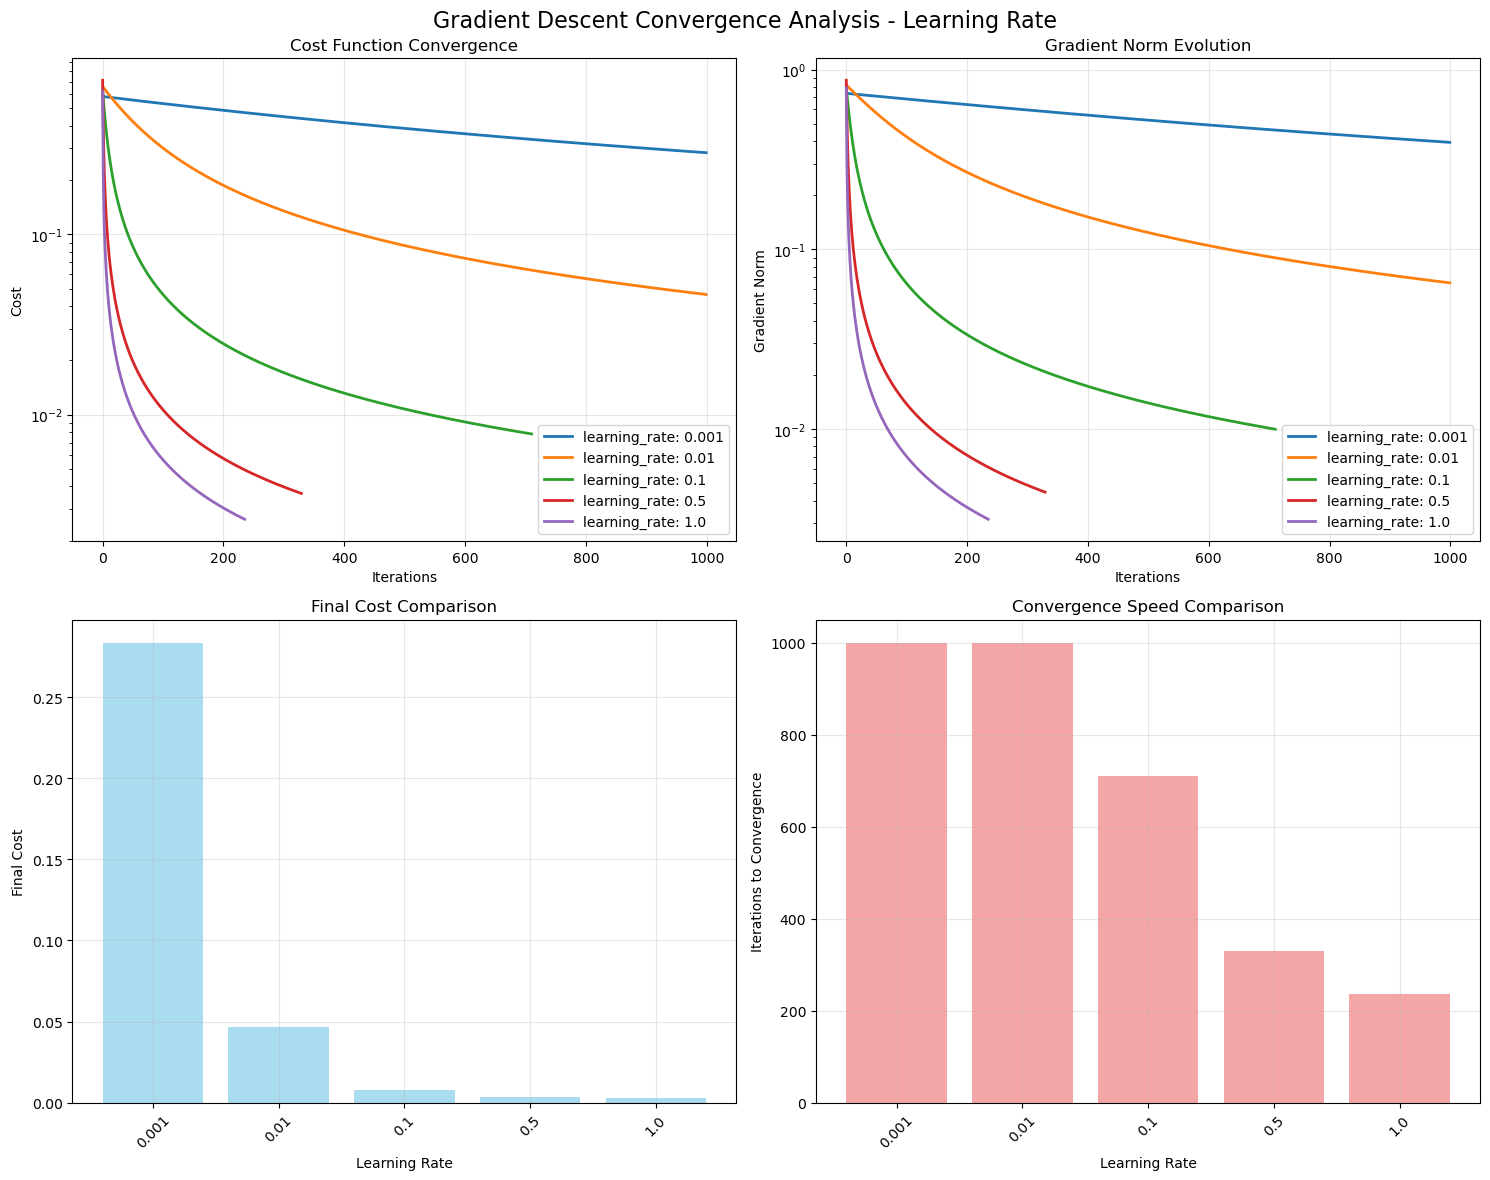

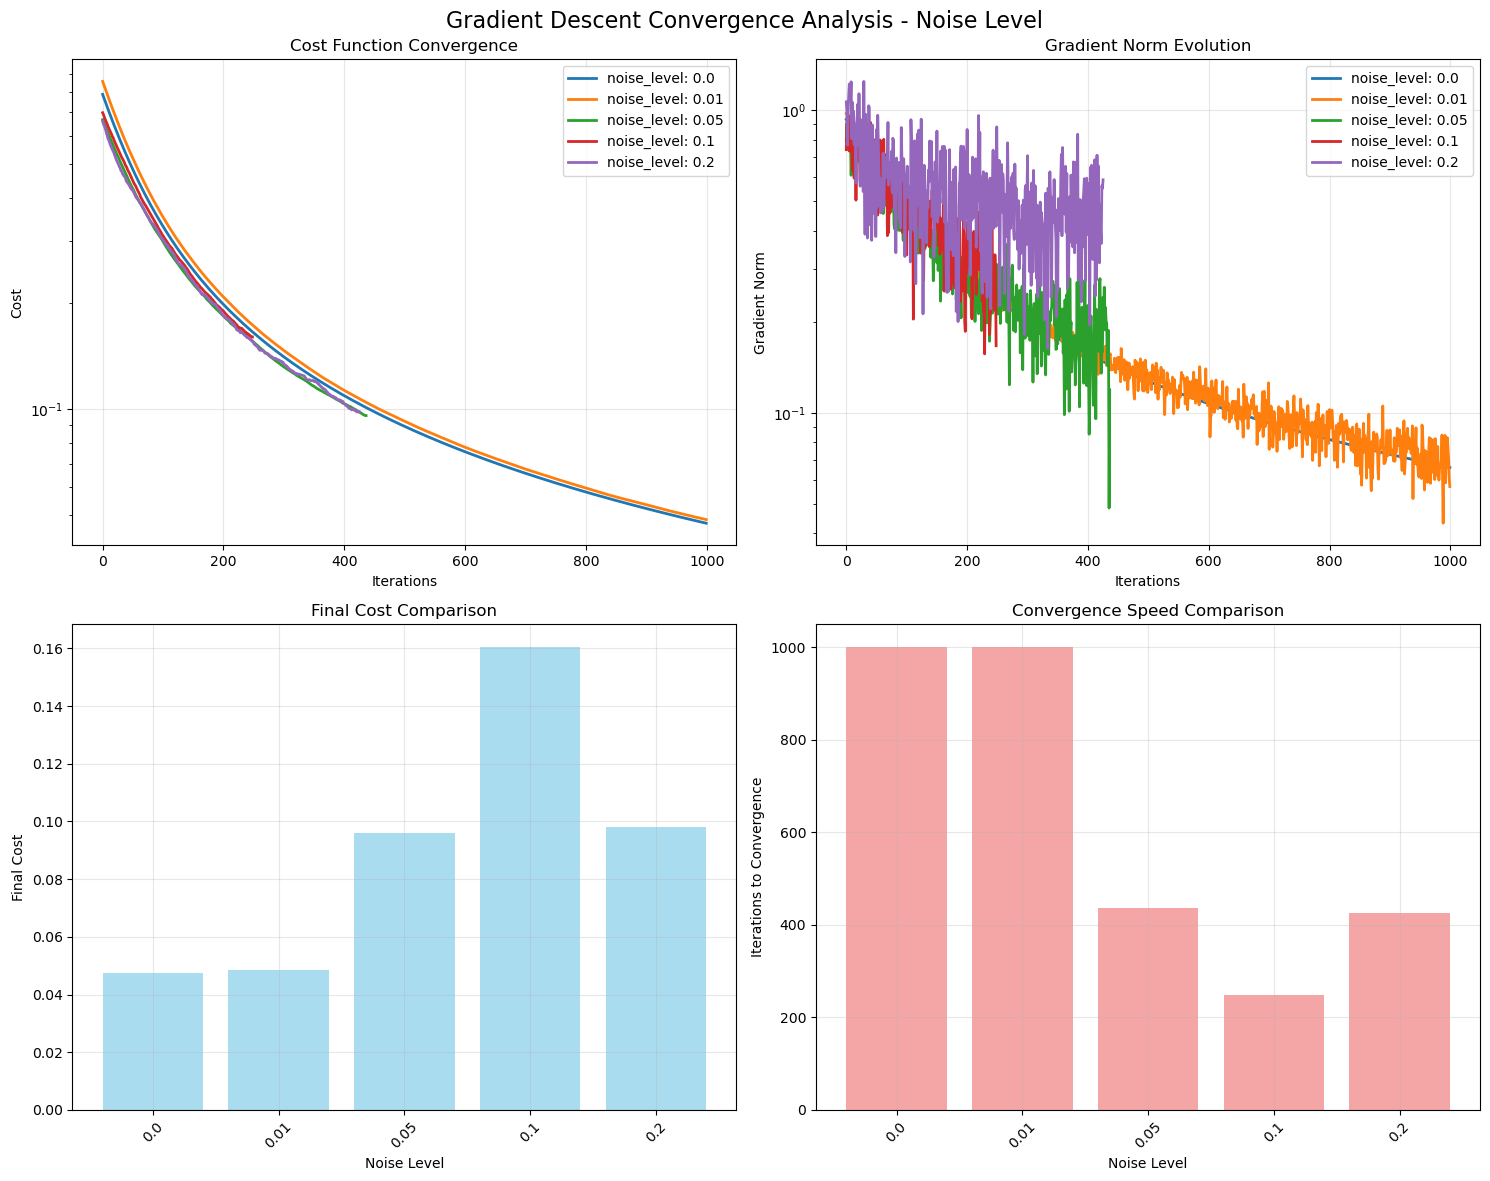

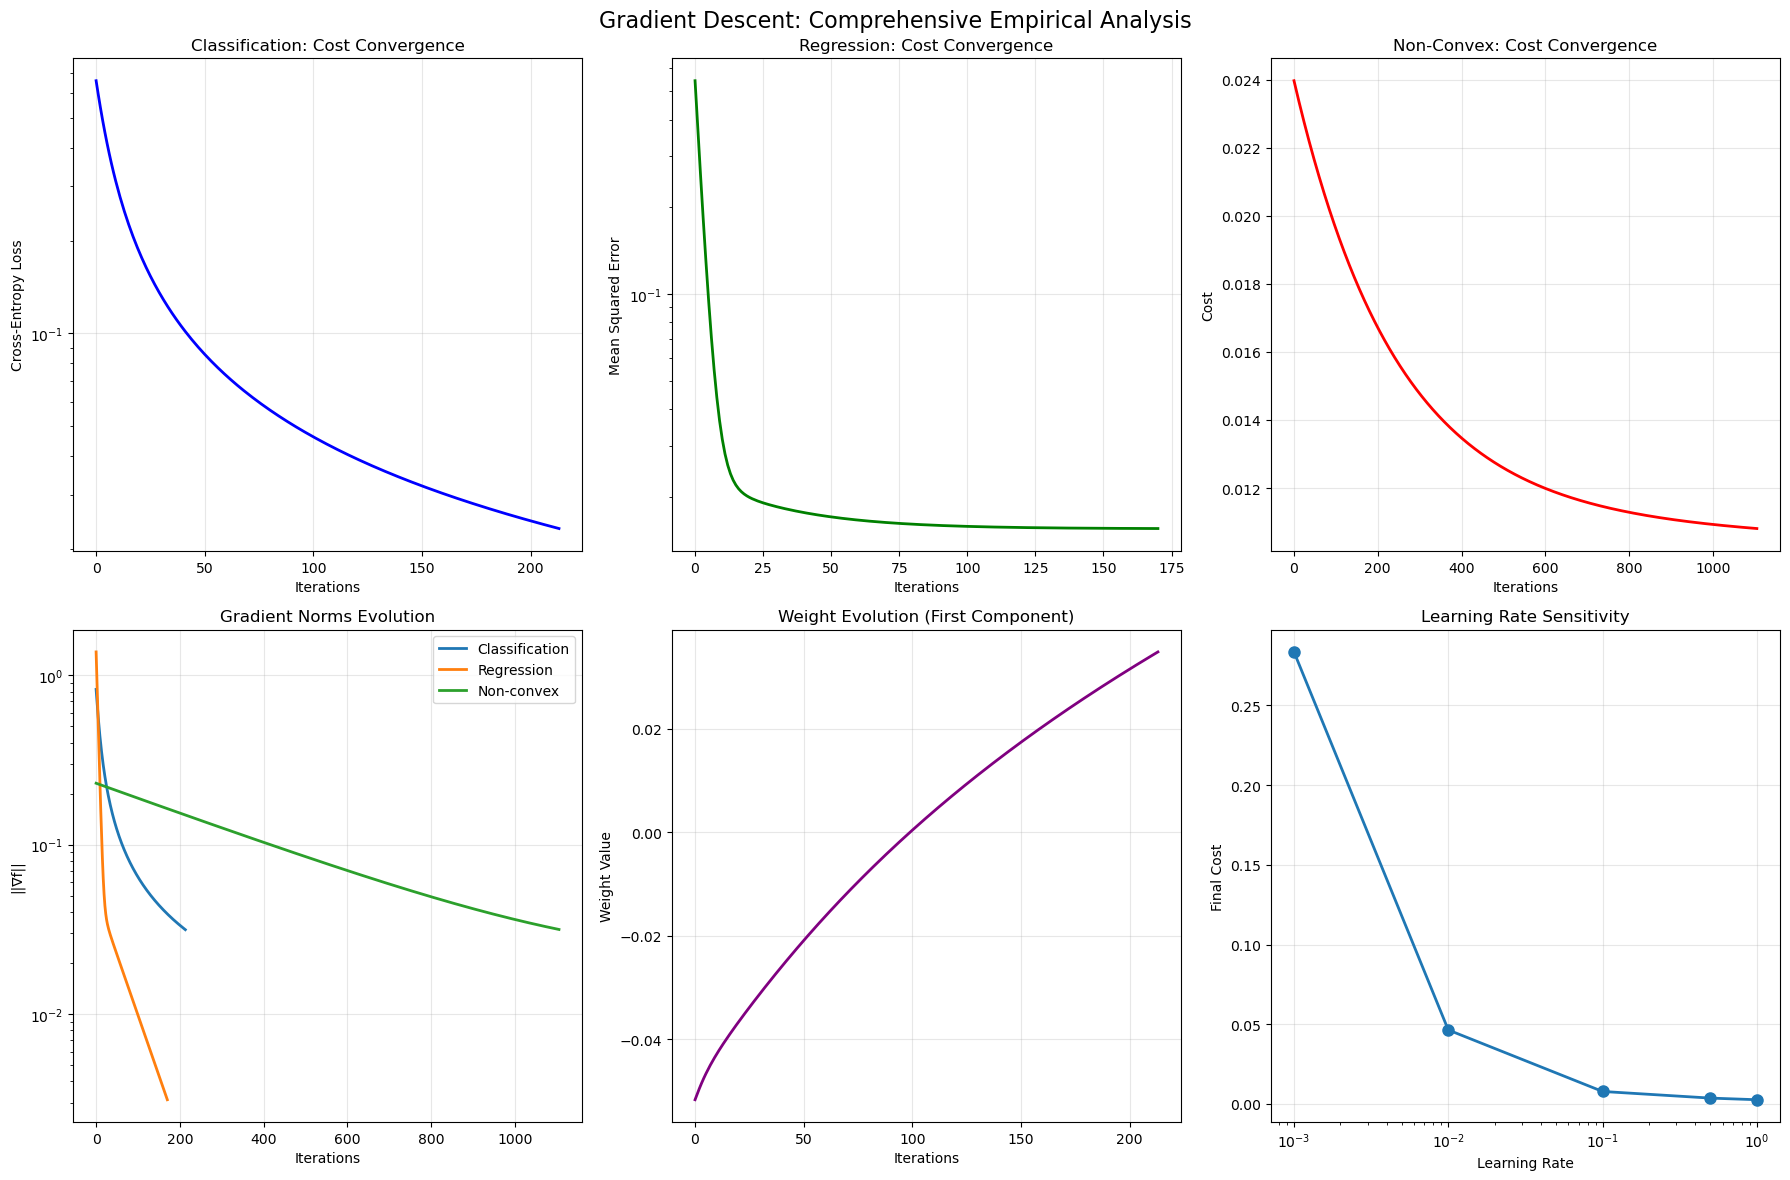


COMPREHENSIVE GRADIENT DESCENT ANALYSIS SUMMARY

1. CONVEX SETTINGS:
   • Classification (Logistic): True convergence in 214 iterations
     Final accuracy: 1.0000
   • Regression (Linear): True convergence in 171 iterations
     Final MSE: 0.035371

2. NON-CONVEX SETTINGS:
   • Non-convex optimization: True convergence in 1106 iterations
     Final cost: 0.010812

3. EMPIRICAL ANALYSIS RESULTS:
   • Optimal learning rate: 1.0
   • Learning rate range tested: 0.001 - 1.0
   • Gradient noise impact (0.1 level): +238.76% change in final cost
   • Average gradient norm at convergence: 0.032116


In [13]:
if __name__ == "__main__":
    results = demonstrate_gradient_descent()